In [139]:
import nltk
import pandas
import re

nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

nltk.download("vader_lexicon")
nltk.download("stopwords")


from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

from nltk.data import find
import numpy as np


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davidkivlichan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/davidkivlichan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidkivlichan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [140]:
from tqdm import tqdm 

# Data Cleaning

In [141]:
tweets = open('Dataset_Name.csv','r').read()
OriginalTweets = tweets.split('\n')

len(OriginalTweets)

9641

In [142]:
OriginalTweets[0].split(',')

['id',
 'tweetid',
 'guid',
 'link',
 'author',
 'title',
 'description',
 'pubdate',
 'source',
 'favorite_count',
 'retweet_count',
 'lang',
 'quoted_text',
 'tweet_type',
 'in_reply_to_screen_name',
 'in_reply_to_user_id',
 'in_reply_to_status_id',
 'retweeted_screen_name',
 'retweeted_user_id',
 'retweeted_status_id',
 'user_id',
 'profile_image_url',
 'user_statuses_count',
 'user_friends_count',
 'user_followers_count',
 'user_created_at',
 'user_bio',
 'user_location',
 'user_verified',
 '']

In [143]:
del OriginalTweets[-1] #Blank line removed
del OriginalTweets[0] #column header line removed
OriginalTweets[101].split(',')

['102',
 '1445097097674596358',
 '"https://twitter.com/kathleenogrady/statuses/1445097097674596358"',
 '"https://twitter.com/kathleenogrady/statuses/1445097097674596358"',
 '"kathleenogrady"',
 '"Terrific news #cdnpoli #aging #seniors #cdnfem #fem2 https://t.co/SxT5ZJGtMP"',
 '"Terrific news #cdnpoli #aging #seniors #cdnfem #fem2 https://t.co/SxT5ZJGtMP"',
 '"2021-10-04 14:42:51"',
 '"Twitter for iPhone"',
 '0',
 '0',
 '"en"',
 '"So proud and excited to be part of the launch of #WomensAgeLab at @WCHospital @WCRInstitute   The First &amp; Only center of its kind in the world dedicated to older women.   Great way to honor October 1st',
 ' the International Day of Older Persons  https://t.co/bNt6SObx9d  #UNIDOP2021 https://t.co/dQxTTtpm9b"',
 '"quote"',
 '"_SurbhiKalia"',
 '1095480773438832640',
 '1443948458151448579',
 '""',
 '0',
 '0',
 '67763905',
 '"https://pbs.twimg.com/profile_images/1430005448317587460/l4BTkYuz_normal.jpg"',
 '57411',
 '7887',
 '7940',
 '"2009-08-21 20:22:00"',
 '"

In [144]:
#remove everything but text in the tweet
#take only tweets from the past day.
#since some tweets use commas, can find the date of the tweet (2021), to find where the tweet ends after split
tweetsOnly = [' '.join(list(tweet.split(',')[6:i+7])) for tweet in OriginalTweets for i,x in enumerate(tweet.split(',')[7:]) if '2021-10-04' in x]
len(tweetsOnly)

9645

In [145]:
tweetsOnly[101]

'"Terrific news #cdnpoli #aging #seniors #cdnfem #fem2 https://t.co/SxT5ZJGtMP"'

In [146]:
# Remove all html tags and attributes
print(tweetsOnly[541])
tweets = [tweet.replace('&lt;', '').replace('\\', '').replace("&gt;","").replace("&quot;",'"').replace("&amp;","&") for tweet in tweetsOnly]
tweets = [re.sub('<[^<]+?>', '', x) for x in tweets]
#Check
print(tweets[541])

"I think a good way to mark this occasion is to donate to @mohamadfakih8’s campaign to provide Thanksgiving Dinner to those who need it this year -&gt; https://t.co/K4eJE9rFpl #cdnpoli https://t.co/9GleW3l9rs"
"I think a good way to mark this occasion is to donate to @mohamadfakih8’s campaign to provide Thanksgiving Dinner to those who need it this year - https://t.co/K4eJE9rFpl #cdnpoli https://t.co/9GleW3l9rs"


In [147]:
# All URLs are removed.
print(tweets[0])
tweetsCleaned = [re.sub(r'http\S+', '', x) for x in tweets]
#check
print(tweetsCleaned[0])

"Hundreds of small businesses in Ontario are publicly opposing the government’s vaccine passport system and many are staying quiet about their opposition but not enforcing the system on their customers.  @anthonyfurey discusses. #cdnpoli   https://t.co/foXTj9DTiS"
"Hundreds of small businesses in Ontario are publicly opposing the government’s vaccine passport system and many are staying quiet about their opposition but not enforcing the system on their customers.  @anthonyfurey discusses. #cdnpoli   


In [148]:
#All lowercase
tweetsCleaned = [x.lower() for x in tweetsCleaned]
tweetsCleaned = [x.replace("\\","") for x in tweetsCleaned]

In [149]:
#Html character codes (i.e., &...;) are replaced with an ASCII equivalent
tweetsASCII = [x.encode('unicode-escape').decode('ascii') for x in tweetsCleaned]

In [150]:
#Many hashtags contain these words
liberal_list = ['lpc','libera','justin','trude','snc','lav','face','chooseforward', 'surfboard']
conservative_list = ['conserv','erin', 'toole','ford','cpc','harper', 'tory', 'tories','bigbluewave']
ndp_list = ['new democrat','ndp','jagmeet','singh','layton','mulcair','orange']
green_list = ['green party', 'annamie', 'paul', 'gpc'] 
bloc_list = ['bloc ', 'québécois', 'quebécois', 'québecois', 'quebecois', 'yves', 'françois','francois', 'blanchet']

from collections import Counter
#For each tweet, count how many words from each party's list they contain.
#if sum of word counts is 0, then classify it as none
array_party = np.array([])
for pol_tweet in tweetsCleaned:
    lib_count = 0
    con_count = 0
    ndp_count = 0
    bloc_count = 0
    gpc_count = 0
    for keyword in liberal_list:
        if keyword in pol_tweet:
            lib_count += pol_tweet.count(keyword)
    for keyword in green_list:
        if keyword in pol_tweet:
            gpc_count += pol_tweet.count(keyword)
    for keyword in bloc_list:
        if keyword in pol_tweet:
            bloc_count += pol_tweet.count(keyword)
    for keyword in conservative_list:
        if keyword in pol_tweet:
            con_count += pol_tweet.count(keyword)
    for keyword in ndp_list:
        if keyword in pol_tweet:
            ndp_count += pol_tweet.count(keyword)
    
    if lib_count + con_count + ndp_count + gpc_count + bloc_count== 0:
         array_party = np.append(array_party,'none')
    elif all([ndp_count >= con_count, ndp_count >= lib_count, ndp_count >= gpc_count, ndp_count >= bloc_count]):
        array_party = np.append(array_party,'ndp')
    elif all([lib_count >= con_count, lib_count >= ndp_count, lib_count >= gpc_count, lib_count >= bloc_count]):
        array_party = np.append(array_party,'liberal')
    elif all([con_count >= lib_count, con_count >= ndp_count, con_count >= gpc_count, con_count >= bloc_count]):
        array_party = np.append(array_party,'conservative')
    elif all([gpc_count >= con_count, gpc_count >= ndp_count, gpc_count >= lib_count, gpc_count >= bloc_count]):
        array_party = np.append(array_party,'green')
    elif all([bloc_count >= con_count, bloc_count >= ndp_count, bloc_count >= lib_count, bloc_count >= gpc_count]):
        array_party = np.append(array_party,'bloc')
    else:
        array_party = np.append(array_party,'ndp')
#drop first element <built-in function array>

(array(['bloc', 'conservative', 'green', 'liberal', 'ndp', 'none'],
       dtype='<U32'),
 array([   2, 1549,  118, 2234,  296, 5446]))

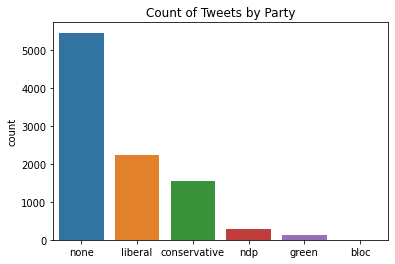

In [151]:
# Distribution of political tweets
sns.countplot(x=array_party).set_title("Count of Tweets by Party")
np.unique(array_party,return_counts=True)

In [205]:
new_words = {
    'surfboard': -4
}

In [206]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    SIA = SentimentIntensityAnalyzer()

    SIA.lexicon.update(new_words)
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = SIA.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [207]:
tweets = evalSentences(tweetsCleaned, to_df=True, columns=['tweets','vader'])

100%|██████████| 9645/9645 [00:02<00:00, 3992.20it/s]


In [208]:
party = pandas.DataFrame(array_party)
party.columns = ['party']
tweets_vader = tweets.join(party)

In [209]:
tweets_vader[['vader', 'party']].groupby(['party']).mean().sort_values('vader',ascending=0)

,vader
party,
bloc,0.810500
ndp,0.203319
conservative,0.070254
none,-0.011228
liberal,-0.029779
green,-0.103719


In [210]:
tweets_vader[tweets_vader['party'] == 'liberal']

,tweets,vader,party
3,"""“why can’t you say anything about the prime m...",0.1280,liberal
6,"""“his surfboard is a very difficult fit into a...",-0.5130,liberal
13,"""afghan women ministers warned canada of talib...",-0.5871,liberal
21,"""“his surfboard is a very difficult fit into a...",-0.5130,liberal
23,"""“his surfboard is a very difficult fit into a...",-0.5130,liberal
25,"""from @brianlilley: trudeau's apology too late...",-0.5847,liberal
27,"""@krismeloche how about @facebook permanently ...",0.0000,liberal
31,"""october 4th in canada there are 45 long-term ...",-0.6249,liberal
32,"""statement from assembly of first nations nati...",0.3182,liberal
34,"""“his surfboard is a very difficult fit into a...",-0.5130,liberal


In [211]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(tweets_df, k=50):
    tweets = tweets_df['tweets'].values
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    stop.add('canada')
    stop.add('cdnpoli')
    stop.add('people')
    stop.add('elxn44')
    stop.add('one')
    stop.add('first')
    stop.add('story')
    stop.add('trudeau')
    stop.add('justintrudeau')
    stop.add('canadians')
    stop.add('people')
    stop.add('elxn44')
    # Top-k frequent terms
    counter = Counter()
    for tweet in tweets:
            counter.update([word
                            for word 
                            in re.findall(r'\w+', tweet) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqTweet = []
    for tweet in tweets:
        tempCounter = Counter([word for word in re.findall(r'\w+',tweet)])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqTweet.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqTweet_df = pandas.DataFrame(freqTweet)
    top_k_words = []
    for word, count in topk:
        top_k_words.append(word)
    freqTweet_df.columns = top_k_words
    finalTweet = tweets_df.join(freqTweet_df)
    #finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finalTweet

In [212]:
# getting the top-10 most frequent non-stopwords in the review collection
topk, finaldf = dataFrameTransformation(tweets_vader, k=100)

In [213]:
connotations = np.where(finaldf['vader']>0, 'positive', 'negative')

In [214]:
connotations_df = pandas.DataFrame(connotations, columns = ['connotation'])

In [215]:
final_df = finaldf.join(connotations_df)

In [216]:
final_df.head()

,tweets,vader,party,tax,onpoli,ableg,media,day,tofino,alberta,...,going,closing,dodging,term,read,federal,take,facebook,conservative,connotation
0,"""hundreds of small businesses in ontario are p...",0.0000,none,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,"""entitled and privileged. a liar and hypocrite...",0.1779,none,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
2,"""charter rights: 'this year’s [supreme court c...",0.0000,none,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
3,"""“why can’t you say anything about the prime m...",0.1280,liberal,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,positive
4,"""if the canadian media ever wonders how donald...",0.4215,none,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,positive


In [217]:
Ground = final_df.groupby(['party', 'connotation']).sum().drop(['vader'], axis = 1)

In [218]:
pandas.set_option("display.max_rows", None)

<AxesSubplot:title={'center':'most common words in conservative-positive tweets'}>

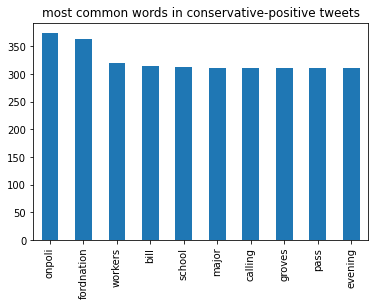

In [219]:
Ground.T.sort_values(by=('conservative','positive'), ascending = 0)[('conservative','positive')].head(10).plot(kind='bar', title="most common words in conservative-positive tweets")

<AxesSubplot:title={'center':'most common words in conservative-negative tweets'}>

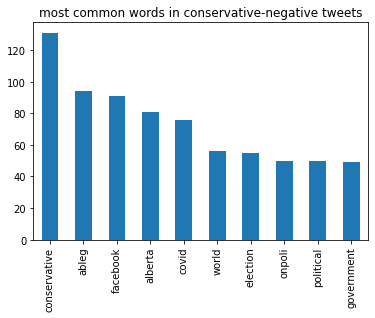

In [220]:
group = ('conservative', 'negative')
Ground.T.sort_values(by=group, ascending = 0)[group].head(10).plot(kind='bar', title="most common words in {}-{} tweets".format(group[0], group[1]))

<AxesSubplot:title={'center':'most common words in liberal-positive tweets'}>

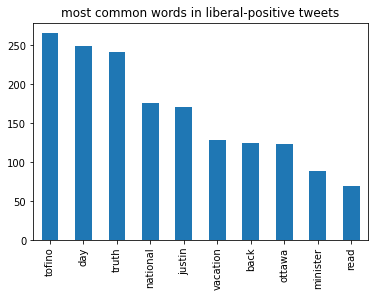

In [221]:
group = ('liberal', 'positive')
Ground.T.sort_values(by=group, ascending = 0)[group].head(10).plot(kind='bar', title="most common words in {}-{} tweets".format(group[0], group[1]))

<AxesSubplot:title={'center':'most common words in liberal-negative tweets'}>

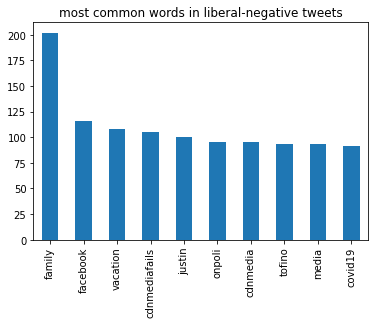

In [222]:
group = ('liberal', 'negative')
Ground.T.sort_values(by=group, ascending = 0)[group].head(10).plot(kind='bar', title="most common words in {}-{} tweets".format(group[0], group[1]))

<AxesSubplot:title={'center':'most common words in ndp-positive tweets'}>

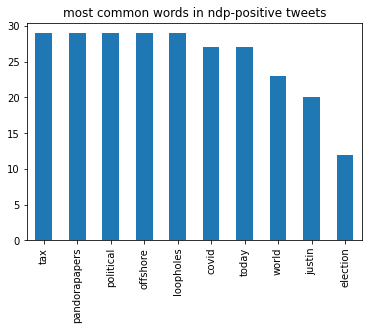

In [223]:
group = ('ndp', 'positive')
Ground.T.sort_values(by=group, ascending = 0)[group].head(10).plot(kind='bar', title="most common words in {}-{} tweets".format(group[0], group[1]))

<AxesSubplot:title={'center':'most common words in ndp-negative tweets'}>

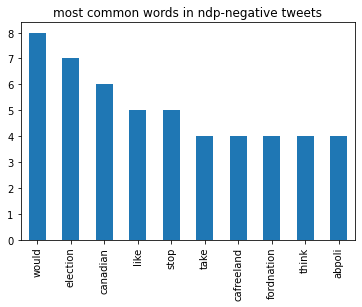

In [224]:
group = ('ndp', 'negative')
Ground.T.sort_values(by=group, ascending = 0)[group].head(10).plot(kind='bar', title="most common words in {}-{} tweets".format(group[0], group[1]))

In [225]:
party_sentiments = final_df[['party','connotation']].value_counts()

In [226]:
partys = []
sentiments = []
for party, sentiment in party_sentiments.keys():
    partys.append(party)
    sentiments.append(sentiment)

In [227]:
counts = list(party_sentiments)

In [228]:
party_labels = list(set(partys))
party_sentiment_counts = zip(partys, sentiments, counts)
liberal_counts = [1,2]
conservative_counts = [1,2]
ndp_counts = [1,2]
for party, sentiment, count in party_sentiment_counts:
    if party == 'liberal' and sentiment == "positive":
        liberal_counts[0] = count
    if party == 'liberal' and sentiment == "negative":
        liberal_counts[1] = count
    if party == 'conservative' and sentiment == "positive":
        conservative_counts[0] = count
    if party == 'conservative' and sentiment == "negative":
        conservative_counts[1] = count
    if party == 'ndp' and sentiment == "positive":
        ndp_counts[0] = count
    if party == 'ndp' and sentiment == "negative":
        ndp_counts[1] = count

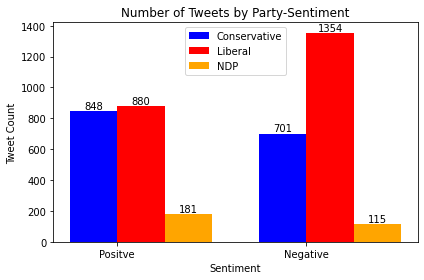

In [229]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Positve', 'Negative']

#men_means = [20, 34, 30, 35, 27]
#women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, conservative_counts, width, label='Conservative', color = "blue")
rects2 = ax.bar(x + width/2, liberal_counts, width, label='Liberal', color = "red")
rects3 = ax.bar(x + 3*width/2, ndp_counts, width, label='NDP', color = "orange")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Tweet Count')
ax.set_xlabel('Sentiment')
ax.set_title('Number of Tweets by Party-Sentiment')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 9)

ax.bar_label(rects1, padding=0)
ax.bar_label(rects2, padding=0)
ax.bar_label(rects3, padding=0)

fig.tight_layout()

plt.show()